In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt

%load_ext rpy2.ipython
import pandas as pd
import numpy as np

import os
os.chdir("/Users/lucapozzi/repos/Arlem/")

## Generate Data

In [2]:
from harlem.data.data_generator import DataGeneratorHarlem

In [3]:
%%capture
data_gen = DataGeneratorHarlem()

In [4]:
# [1] -0.36068676  0.01080478
data_gen.theta

array([-0.35714169,  0.0106924 ])

In [5]:
full_data, _ = data_gen.data_generator(5000)

seed: 1544583632


In [6]:
delta_star = max(np.abs(np.diff(sorted(full_data.w))))
print(delta_star)

1.1922774712356414


## Test vs. R

In [7]:
n_grid = 300
tau = 100

In [8]:
%%R -i full_data -i n_grid -i tau

library("HARLEM")
library("splines")

lambdaConst <- function(tau){
    function(x){
        if(x<10)return(0)
        if(x>70)return(0)
        return(1)
    }
}
lambdaConst <- Vectorize(lambdaConst(tau))


dataGen <- dataGenHARLEM(delta=3, 100, lambda=lambdaConst,rate=0.017)
truth <- dataGen$theta
print(truth)

truth <- dataGen$theta
lambda <- dataGen$lambda
nGrid <- 300


xGrid <- seq(0,tau,length.out=n_grid)
vGrid <- seq(0,tau,length.out=n_grid)


deltaStar <- max(diff(sort(full_data$w)))
print(deltaStar)

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: copula

  warnings.warn(x, RRuntimeWarning)


[1] -0.36068676  0.01080478
[1] 1.192277


In [9]:
data_gen.theta

array([-0.35714169,  0.0106924 ])

## Initialization

In [10]:
x_grid = np.linspace(0, tau, num=n_grid)
v_grid = np.linspace(0, tau, num=n_grid)

### Q's

In [11]:
from harlem.parameters.init_Q import init_Q

In [72]:
%%time
# Normalization Constant: [1] 1.178421
Q0 = init_Q(full_data, x_grid, v_grid, delta_star, tau=tau, verbose=True)
Q1, Q2 = Q0

h Opt [2.83450909 1.93147699]
Renormalization Constant: 0.9380561680074634
CPU times: user 55.6 s, sys: 2.19 s, total: 57.8 s
Wall time: 1min 1s


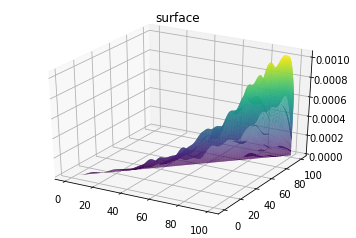

In [73]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.plot_surface(x_grid, v_grid, Q2, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface');


In [14]:
%%R
#source("~/repos/HARLEM/R/initFun.R")
cat("Initializing the Q's...\n")
Q0 <- initQ(full_data,xGrid,vGrid, deltaStar,tau=tau, verbose=TRUE); Q1 <- Q0[[1]]; Q2 <- Q0[[2]]
Sn <- Q1$Sn; Qc <- Q1$Qc; dGn <- Q1$dGn
hOpt <- attr(Q2,"hOpt")

Initializing the Q's...
a= -4.369747  b= 4.382972 
c= 0.698671  d= 4.587665 

****
h Opt.[1] 0.1412625 0.0500000


$Q_1$ is on top (close enough...)

In [15]:
print(Q1['Sn'](50))
print(Q1['dGn'][:5])
print(Q1['Qc'](60))

0.5054104548103782
[0.00040136 0.0003445  0.00015556 0.00014977 0.00015742]
0.3143970734004037


In [16]:
%%R
print(Q0[[1]]$Sn(50))
print(Q0[[1]]$dGn[1:5])
print(Q0[[1]]$Qc(60))

[1] 0.5054105
[1] 0.0004013555 0.0003444992 0.0001555581 0.0001497697 0.0001574208
[1] 0.3143971


$Q_2$ is a bit off...

In [74]:
(Q2==0).mean()

0.5116

In [75]:
%R mean(Q0[[2]]==0)

array([0.65307778])

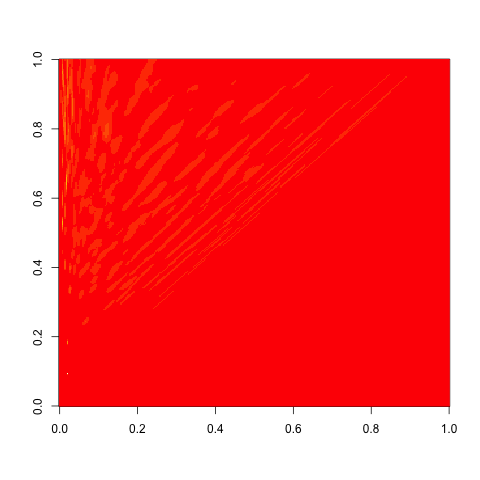

In [76]:
%%R -i Q2
image(t(Q0[[2]]) - Q2)

In [77]:
%R max(Q0[[2]])

array([0.00362003])

In [78]:
Q2.max()

0.001041364950394628

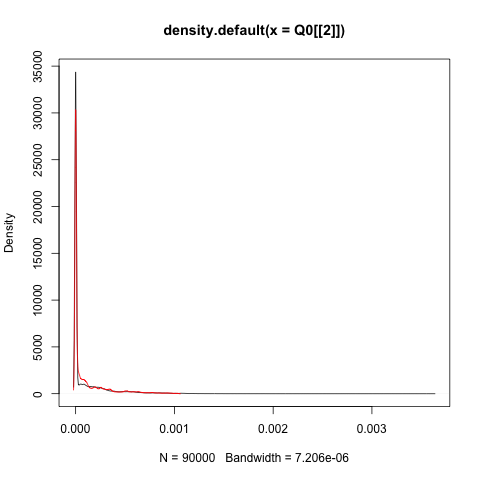

In [55]:
%%R
plot(density(Q0[[2]]))
lines(density(Q2), col='red')

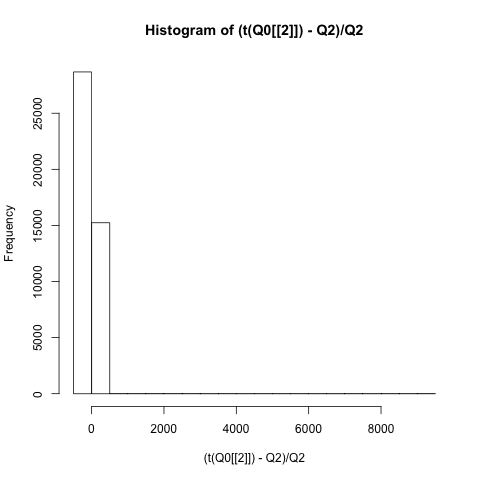

In [20]:
%%R
hist((t(Q0[[2]]) - Q2)/Q2)

In [21]:
%R hOpt

array([0.14126246, 0.05      ])

### T's

In [22]:
from harlem.parameters.init_T import init_T

In [23]:
%%time
T0 = init_T(full_data, Q1['Qc'], Q1['dGn'], delta_star, x_grid, v_grid)
T1, T2 = T0

CPU times: user 6.82 s, sys: 27.3 ms, total: 6.85 s
Wall time: 6.86 s


In [24]:
print((T1==0).mean(), (T1!=0).sum())
print((T2==0).mean(), (T2!=0).sum())

0.5116 43956
0.5116 43956


In [25]:
%%R
cat("Initializing the T's...\n")
T0 <- initT(full_data,Qc,dGn,deltaStar,xGrid,vGrid); T1 <- T0[[1]]; T2 <- T0[[2]]

Initializing the T's...


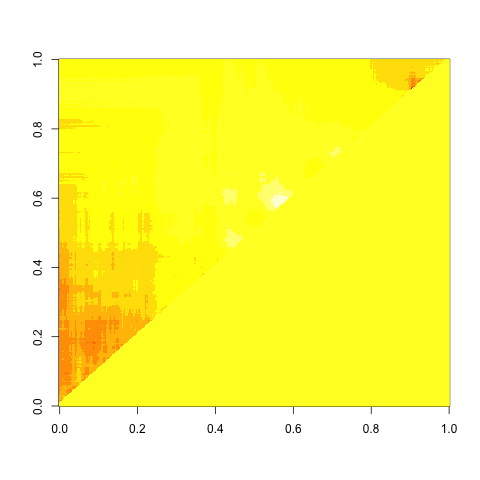

In [26]:
%%R -i T1
image(t(T0[[1]]) - T1)

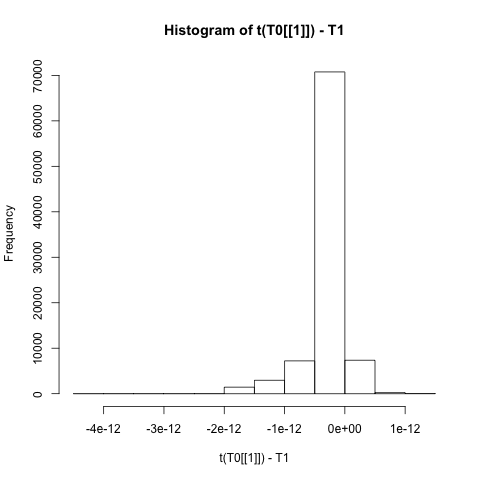

In [27]:
%%R
hist(t(T0[[1]]) - T1)

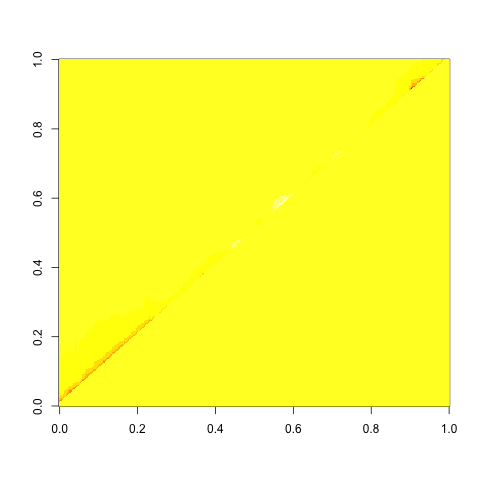

In [28]:
%%R -i T2
image(t(T0[[2]]) - T2)

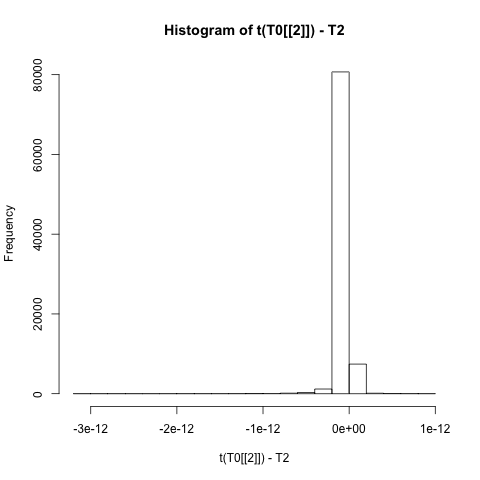

In [29]:
%%R
hist(t(T0[[2]]) - T2)

In [30]:
%%R
print(mean(t(T0[['T1']]) - T1))
print(max(t(T0[['T1']]) - T1))

[1] -1.710935e-13
[1] 1.222134e-12


In [31]:
%%R
print(mean(t(T0[['T2']]) - T2))
print(max(t(T0[['T2']]) - T2))

[1] -1.507097e-14
[1] 9.094947e-13


## Initial Estimator

In [32]:
%%capture
from harlem.estimator.linear_estimator import LinearEstimator

linear_estimator = LinearEstimator(full_data, T1, T2, Q1,
                                   x_grid, v_grid, delta_star)
theta_linear = linear_estimator.psi(Q2)

In [33]:
theta_linear

array([-0.42639545,  0.01043633])

In [34]:
%%R -i T1 -i T2 -i Q2
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(t(T1),t(T2),Q1,t(Q2),lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.42619799  0.01037212


In [35]:
%%R 
cat(("Initializing  Psi...\n"))
initPsi <- linearPsi(full_data,deltaStar,tau)(T0[[1]],T0[[2]],Q1,Q0[[2]],lambdaConst,xGrid,vGrid)
initPsi

Initializing  Psi...
[1] -0.358458507  0.007392423


- TODO: Constant estimator

## Debias

### One Step Estimator

In [83]:
%%capture
from harlem.estimator.debias.one_step import HarlemOneStep
one_step = HarlemOneStep(full_data=full_data, delta_star=delta_star, T0=T0, Q0=Q0)

In [84]:
theta_one_step = one_step.fit()
theta_one_step

[-4.09026337e-06  2.91569474e-07]


array([-0.42994351,  0.01082718])

In [38]:
one_step.init_psi

array([-0.42639545,  0.01043633])

In [39]:
theta_linear

array([-0.42639545,  0.01043633])

In [81]:
%%R
library(HARLEM)
cat("Running One Step...\n")
one_step <- harlem1Step(full_data,linearPsi(full_data,deltaStar,tau),deltaStar,tau,nGrid,
                        lambda=Vectorize(function(x)1*((x>=10)&(x<=70))),
                        Q0=list(Q1=Q1, Q2=t(Q2)),T0=list(T1=t(T1), T2=t(T2)))
one_step

Running One Step...
            [,1]
[1,] -3.16011859
[2,]  0.04160081


In [82]:
%%R -i Q2
cat("Running One Step...\n")
one_step <- harlem1Step(full_data,linearPsi(full_data,deltaStar,tau),deltaStar,tau,nGrid,
                        lambda=Vectorize(function(x)1*((x>=10)&(x<=70))),
                        Q0=Q0,T0=T0)
one_step

Running One Step...
             [,1]
[1,] -0.386311013
[2,]  0.007732255


### TMLE

In [92]:
%%capture
from harlem.estimator.debias.tmle import HarlemTMLE
tmle = HarlemTMLE(full_data=full_data, delta_star=delta_star, Q0=Q0, T0=T0, verbose=True)

In [93]:
%%time
tmle.fit()

0 Epsilon: [-3.33330660e-05  5.61812985e-07]
Log-likelihood: -7.888470034330619
Renormalization Constant: 1.0
D: [-0.11932577  0.1570381 ], |  log-Likelihood = -7.888470034330619
Stopping: 0.15703809567635035 - 0.022541740866685808
1 Epsilon: [-3.29588105e-05  5.56080981e-07]
Log-likelihood: -7.888480645703195
Renormalization Constant: 1.0
D: [-0.1192395   0.15652423], |  log-Likelihood = -7.888480645703195
Stopping: 0.1565242292891898 - 0.022541740866685808
2 Epsilon: [-3.25970349e-05  5.50622697e-07]
Log-likelihood: -7.888491510094416
Renormalization Constant: 1.0
D: [-0.11915337  0.15601981], |  log-Likelihood = -7.888491510094416
Stopping: 0.15601980889267322 - 0.022541740866685808
3 Epsilon: [-3.22544931e-05  5.45311031e-07]
Log-likelihood: -7.888502610383162
Renormalization Constant: 1.0
D: [-0.11906763  0.15552447], |  log-Likelihood = -7.888502610383162
Stopping: 0.1555244682238412 - 0.022541740866685808
4 Epsilon: [-3.19238365e-05  5.40248953e-07]
Log-likelihood: -7.8885139644

KeyboardInterrupt: 

In [ ]:



constraints=[LinearConstraint(A=grad_max, lb=-1, ub=1)]

def cons(x):
    a = np.array([[-1, -1, -1, -1], [-3, -3, -2, -1]])
    return np.concatenate([np.dot(a, x) + np.array([5, 10]), x])
constraints={'type': 'ineq', 'fun': cons})

In [ ]:
%%R
cat("Running TMLE...\n")
TMLE <- harlemTMLE(full_data,stepLinear(full_data, deltaStar,tau,lambdaConst,1/sqrt(nrow(obsData))),
                   linearPsi(full_data,deltaStar,tau), deltaStar,tau,nGrid=nGrid, Q0=Q0,T0=T0)

In [1]:
%R names(TMLE)

UsageError: Line magic function `%R` not found.


In [2]:
%R TMLE[['Q2']]

UsageError: Line magic function `%R` not found.


In [277]:
%R TMLE[['thetaHat']]

array([[-0.52126093, -1.00357283],
       [ 0.01160983,  0.02329393]])

## TODOS

- test survival functions vs. `R`
- 